# Patially Linear IV models using Double Machine Learning

Without water

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api
import scipy
import statsmodels
from sklearn.base import clone
import doubleml as dml
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [2]:
#import transformed dataset that's ready for use
df_log=pd.read_csv("dataframe_transformed_4_log.csv")

In [3]:
df_log=df_log[df_log['ARTICLE_CAT_2_WATER']==0]

In [4]:
#Some additional transformations:

# The zero demand observations become -infinity because of the log-transformation
# These values should be deleted or replaced:
    # the observations with zero demand will be deleted, however in the lagged demand variable this data is still needed
    # So choose a value to impute these -infinity values with: Preferably np.NaN such that no bias will occur

# Based on what first stage method you will use, it may or may not be able to handle missing values. 
# Create an imputed value for the methods that cannot use NaNs
# Here: the missing values are most often referring to a promo period, hence a MAX value for demand is imputed to act as a surrogate for this promo demand.


# Include dummy variab;e for holidays and other special dates that can explain irregular demand
listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_log['HOLIDAY']=(df_log['WEEK_START_DATE'].isin(listofHolidays))*1

# non-log-transformed week number (do not need log-interpretatation of this variable ("percentage increase in week number leads to percentage change in demand or price" --> should be "absolute change in weeks lead to percentage change demand/price")
# (inflation measure)
df_log['WEEK_NR']=np.round(np.exp(df_log['L_WEEK_NR']))

Model set up: create datasets


In [5]:
x_lasso= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       # 'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',  #'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' , # use imputed value instead of NaN
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       'HOLIDAY', 'WEEK_NR'
       ]]
y_lasso = df_log['L_PRODUCT_ORDER_AMT']
p_lasso = df_log['L_AVG_SELL_PRICE']
z_lasso = df_log['L_AVG_PURCHASE_PRICE']

naiveset_lasso=x_lasso.join(p_lasso.to_frame()) # For OLS
dmlset_lasso=x_lasso.join(y_lasso.to_frame().join(p_lasso.to_frame().join(z_lasso.to_frame()))) #needed in dml algortihm

In [6]:
x_lasso_train, x_lasso_test, y_lasso_train, y_lasso_test, p_lasso_train, p_lasso_test, z_lasso_train, z_lasso_test, naiveset_lasso_train, naiveset_lasso_test, dmlset_lasso_train, dmlset_lasso_test = train_test_split(x_lasso,y_lasso,p_lasso,z_lasso,naiveset_lasso, dmlset_lasso,random_state=44) #in case want to see how first stages perform

Naive models:


OLS:

In [7]:
from linearmodels.iv import IV2SLS
# IV2SLS(dependent:,exog:,endog:,instru:,weights:)

res_ols = IV2SLS(y_lasso_train, naiveset_lasso_train, None, None).fit(cov_type="unadjusted")
res_ols

OLS Estimation Summary                            
===============================================================================
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3144
Estimator:                         OLS   Adj. R-squared:                 0.3139
No. Observations:                47920   F-statistic:                 2.197e+04
Date:                 Tue, Mar 14 2023   P-value (F-stat)                0.0000
Time:                         13:27:40   Distribution:                 chi2(30)
Cov. Estimator:             unadjusted                                         
                                                                               
                                        Parameter Estimates                                         
====================================================================================================
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
CONST                                28.234     1.0889     25.929     0.0000      26.100      30.369
ARTICLE_TIER_BETTER                  0.3045     0.0174     17.470     0.0000      0.2703      0.3387
ARTICLE_TIER_GOOD                    1.1371     0.0355     32.037     0.0000      1.0675      1.2066
ART_BRAND_TIER_PRICE_ENTRY          -1.2405     0.0581    -21.341     0.0000     -1.3544     -1.1266
ART_BRAND_TIER_PRIVATE_LABEL        -0.7709     0.0275    -27.984     0.0000     -0.8249     -0.7169
PACKAGING_BOX                        1.4741     0.0603     24.445     0.0000      1.3559      1.5923
PACKAGING_CAN                        0.3364     0.0635     5.2999     0.0000      0.2120      0.4608
PACKAGING_PACK                       0.4260     0.0209     20.414     0.0000      0.3851      0.4669
ARTICLE_CAT_2_DRINKPAKJES           -2.2211     0.0885    -25.092     0.0000     -2.3946     -2.0477
ARTICLE_CAT_2_FRUITDRANK            -1.8015     0.0375    -48.054     0.0000     -1.8750     -1.7280
ARTICLE_CAT_2_IJSTHEE               -1.5945     0.0889    -17.941     0.0000     -1.7687     -1.4203
ARTICLE_CAT_2_LIMONADE_SIROPEN      -1.0750     0.0482    -22.280     0.0000     -1.1696     -0.9804
ARTICLE_CAT_2_SAPPEN_SMOOTHIES      -1.0542     0.0475    -22.187     0.0000     -1.1473     -0.9611
ARTICLE_CAT_2_SINAS_LEMON_CASSIS    -0.8364     0.0421    -19.848     0.0000     -0.9190     -0.7538
ARTICLE_CAT_2_SPECIAAL_FRIS         -1.2156     0.0288    -42.223     0.0000     -1.2721     -1.1592
ARTICLE_CAT_2_SPORT_ENERGYDRINK     -1.1217     0.1061    -10.576     0.0000     -1.3296     -0.9139
PROMO_DUMMY                         -1.1134     0.0369    -30.161     0.0000     -1.1858     -1.0411
PPL2                                 0.1219     0.0251     4.8526     0.0000      0.0727      0.1712
PPL3                                -0.0350     0.0250    -1.3984     0.1620     -0.0841      0.0141
POSTPPL1                            -0.2236     0.0295    -7.5882     0.0000     -0.2813     -0.1658
POSTPPL2                            -0.0836     0.0295    -2.8367     0.0046     -0.1413     -0.0258
POSTPPL3                            -0.1887     0.0295    -6.4016     0.0000     -0.2464     -0.1309
L_AVG_HIGH_TEMP                      0.0244     0.0077     3.1660     0.0015      0.0093      0.0395
L_NR_ARTICLES_IN_CAT                -2.1936     0.1940    -11.309     0.0000     -2.5737     -1.8134
L_NR_ARTICLES_IN_CAT_2              -0.6591     0.0884    -7.4594     0.0000     -0.8323     -0.4859
AVG_UNAVAILABILITY_PERC             -0.0211     0.0006    -34.459     0.0000     -0.0223     -0.0199
ART_CONTENT_VOLUME                   0.0005  1.472e-05     32.635     0.0000      0.0005      0.0005
ART_IS_MULTIPACK                    -0.2892     0.0701    -4.1240     0.0000     -0.4267     -0.1518
HOLIDAY                             -0.1359     0.0137    -9.9204     0.0000 

TSLS:

In [8]:
# IV2SLS(dependent:,exog:,endog:,instru:,weights:)
res_tsls = IV2SLS(y_lasso_train, x_lasso_train, p_lasso_train, z_lasso_train).fit()
res_tsls

IV-2SLS Estimation Summary                          
===============================================================================
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3135
Estimator:                     IV-2SLS   Adj. R-squared:                 0.3131
No. Observations:                47920   F-statistic:                 1.928e+04
Date:                 Tue, Mar 14 2023   P-value (F-stat)                0.0000
Time:                         13:27:41   Distribution:                 chi2(30)
Cov. Estimator:                 robust                                         
                                                                               
                                        Parameter Estimates                                         
====================================================================================================
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
CONST                                27.228     1.0979     24.801     0.0000      25.076      29.380
ARTICLE_TIER_BETTER                  0.3775     0.0198     19.102     0.0000      0.3387      0.4162
ARTICLE_TIER_GOOD                    1.2925     0.0389     33.202     0.0000      1.2162      1.3688
ART_BRAND_TIER_PRICE_ENTRY          -1.2387     0.0517    -23.969     0.0000     -1.3400     -1.1374
ART_BRAND_TIER_PRIVATE_LABEL        -0.7590     0.0257    -29.547     0.0000     -0.8094     -0.7087
PACKAGING_BOX                        1.4077     0.0540     26.068     0.0000      1.3018      1.5135
PACKAGING_CAN                        0.5192     0.0659     7.8834     0.0000      0.3901      0.6483
PACKAGING_PACK                       0.4240     0.0216     19.665     0.0000      0.3818      0.4663
ARTICLE_CAT_2_DRINKPAKJES           -2.0082     0.0904    -22.217     0.0000     -2.1854     -1.8310
ARTICLE_CAT_2_FRUITDRANK            -1.8130     0.0381    -47.630     0.0000     -1.8877     -1.7384
ARTICLE_CAT_2_IJSTHEE               -1.5797     0.0909    -17.376     0.0000     -1.7579     -1.4015
ARTICLE_CAT_2_LIMONADE_SIROPEN      -1.1910     0.0516    -23.090     0.0000     -1.2921     -1.0899
ARTICLE_CAT_2_SAPPEN_SMOOTHIES      -1.1158     0.0501    -22.271     0.0000     -1.2140     -1.0176
ARTICLE_CAT_2_SINAS_LEMON_CASSIS    -0.8281     0.0441    -18.796     0.0000     -0.9145     -0.7418
ARTICLE_CAT_2_SPECIAAL_FRIS         -1.2634     0.0305    -41.408     0.0000     -1.3232     -1.2036
ARTICLE_CAT_2_SPORT_ENERGYDRINK     -1.1830     0.1100    -10.755     0.0000     -1.3986     -0.9674
PROMO_DUMMY                         -1.1170     0.0680    -16.426     0.0000     -1.2503     -0.9837
PPL2                                 0.1239     0.0250     4.9491     0.0000      0.0748      0.1729
PPL3                                -0.0341     0.0248    -1.3741     0.1694     -0.0828      0.0146
POSTPPL1                            -0.2192     0.0295    -7.4239     0.0000     -0.2770     -0.1613
POSTPPL2                            -0.0783     0.0297    -2.6352     0.0084     -0.1365     -0.0201
POSTPPL3                            -0.1846     0.0296    -6.2384     0.0000     -0.2426     -0.1266
L_AVG_HIGH_TEMP                      0.0254     0.0078     3.2345     0.0012      0.0100      0.0408
L_NR_ARTICLES_IN_CAT                -2.2062     0.1937    -11.387     0.0000     -2.5860     -1.8265
L_NR_ARTICLES_IN_CAT_2              -0.6446     0.0926    -6.9574     0.0000     -0.8261     -0.4630
AVG_UNAVAILABILITY_PERC             -0.0210     0.0008    -28.015     0.0000     -0.0225     -0.0196
ART_CONTENT_VOLUME                   0.0005  1.447e-05     32.891     0.0000      0.0004      0.0005
ART_IS_MULTIPACK                    -0.5872     0.0772    -7.6062     0.0000     -0.7385     -0.4359
HOLIDAY                             -0.1360     0.0138    -9.8750     0.000

# DML Part

Using Lasso first stage - hyperparameter alpha optimized during fitting as we use LassoCV instead of Lasso

In [9]:
# The actual model:

#define first stage lasso_l, lasso_m, lasso_r
lasso_l = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,y_lasso_train)
lasso_m = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,z_lasso_train)
lasso_r = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,p_lasso_train)

# Create correctly formatted data object based on dml package and DoubleMLData functionality
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE')

# Use data object, defined first stages, number of cross-fitting splits (n_folds)
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, lasso_l, lasso_m, lasso_r)

#Print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 47920

------------------ Score & algorithm ------------------
Score function

In [10]:
# dml_pliv_obj.evaluate_learners(metric=mean_squared_error)

In [11]:
# First stage analysis: to judge first stage models

#fit models
y_pred_L=lasso_l.predict(x_lasso_test)
p_pred_R=lasso_r.predict(x_lasso_test)
z_pred_M=lasso_m.predict(x_lasso_test)
#get residualized vars
y_res_lasso=y_lasso_test-y_pred_L
p_res_lasso=p_lasso_test-p_pred_R
z_res_lasso=z_lasso_test-z_pred_M
#get dataframe of test set only
# testdf=df_log.iloc[p_res_lasso.reset_index()['index'],:]

# #add residuals to test set in order to do visualization/analysis
# testdf['y_res_lasso'] =y_res_lasso
# testdf['p_res_lasso']=p_res_lasso
# testdf['z_res_lasso']=z_res_lasso

#print rmse of predictions
print(mean_squared_error(y_lasso_test, y_pred_L,squared=True))
print(mean_squared_error(p_lasso_test, p_pred_R,squared=True))
print(mean_squared_error(z_lasso_test, z_pred_M,squared=True))

1.5832088272869937
0.16228326979355326
0.2012579450793194


First stage analysis

<AxesSubplot:xlabel='L_AVG_PURCHASE_PRICE', ylabel='L_AVG_SELL_PRICE'>

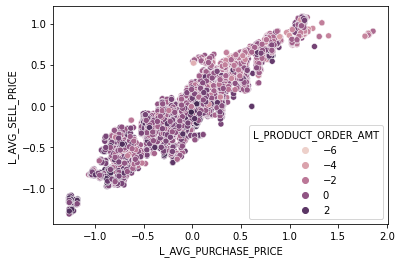

In [12]:
sns.scatterplot(hue=y_res_lasso,y=p_res_lasso, x=z_res_lasso)

In [13]:
np.corrcoef(z_res_lasso,p_res_lasso)  # correlation between p and z -> if too low or high it is a weak instrument

array([[1.       , 0.9264067],
       [0.9264067, 1.       ]])

Using RForest 1st stage 

In [14]:
dmlset_lasso_train.shape

(47920, 33)

In [15]:
# fit first stage models
rfor_l=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, y_lasso_train)
rfor_m=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, z_lasso_train)
rfor_r=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, p_lasso_train)

In [16]:
#create data object
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE')
#run DML model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, rfor_l, rfor_m, rfor_r)
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 47920

------------------ Score & algorithm ------------------
Score function

In [17]:
# dml_pliv_obj.evaluate_learners(metric=mean_squared_error)

First stage analysis

In [18]:
# do predictions and residualize variables in order to do analysis/judgement of first stage
# 
y_pred_L=rfor_l.predict(x_lasso_test)
p_pred_R=rfor_r.predict(x_lasso_test)
z_pred_M=rfor_m.predict(x_lasso_test)
#get residualized vars
y_res_rfor=y_lasso_test-y_pred_L
p_res_rfor=p_lasso_test-p_pred_R
z_res_rfor=z_lasso_test-z_pred_M
#get dataframe of test set only
# testdf=df_log.iloc[p_res_lasso.reset_index()['index'],:]
# add residualized variables to test set such that you can compare them to columns to see potential correlations
# testdf['y_res_rfor'] =y_res_rfor
# testdf['p_res_rfor']=p_res_rfor
# testdf['z_res_rfor']=z_res_rfor
#get rmse of predictions
print(mean_squared_error(y_lasso_test, y_pred_L,squared=True))
print(mean_squared_error(p_lasso_test, p_pred_R,squared=True))
print(mean_squared_error(z_lasso_test, z_pred_M,squared=True))

1.0575779681437634
0.00955654181517728
0.007609930298485958


visual analysis of residualized variables:

In [19]:
np.corrcoef(z_res_rfor,p_res_rfor) # correlation between p and z -> if too low or high it is a weak instrument

array([[1.        , 0.59175161],
       [0.59175161, 1.        ]])

Using XGB first stage 

First replace -inf with nan, as xgboost can handle nan values (but no -inf)

In [20]:
#xgboost can handle np.nan (instead of -inf): - this is for the lagged demand variable which has value of -infinity in case of zero demand (after log transformation of data)
df_log.replace([-np.inf], np.nan, inplace=True)
df_log.replace([-np.inf], np.nan, inplace=True)

In [21]:
# XGBoost new data partition, because of different imputed value for lagged demand
x= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       # 'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2',
       'POSTPPL3', 'L_AVG_HIGH_TEMP'#,'L_TOTAL_ORDER_AMT'
       ,'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',# 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' 
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       'HOLIDAY','WEEK_NR'
       ]]
y = df_log['L_PRODUCT_ORDER_AMT']
p = df_log['L_AVG_SELL_PRICE']
z = df_log['L_AVG_PURCHASE_PRICE']

dmlset=x.join(y.to_frame().join(p.to_frame().join(z.to_frame()))) #needed in dml algortihm

In [22]:
x_train, x_test, y_train, y_test, p_train, p_test, z_train, z_test, dmlset_train, dmlset_test = train_test_split(x,y,p,z,dmlset,random_state=44) #in case want to see how first stages perform

DML Model: XGB

In [23]:
# fit first stages 
xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,y_train)
xgbr_m=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,z_train)
xgbr_r=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,p_train)
# create data object
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',force_all_x_finite='allow-nan')
# run model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, xgbr_l, xgbr_m, xgbr_r, )
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 47920

------------------ Score & algorithm ------------------
Score function

In [24]:
dmlset.shape

(63894, 33)

In [25]:
# dml_pliv_obj.evaluate_learners(metric=mean_squared_error)

For first stage model evaluation:

In [26]:
#get residualized vars for test set
y_res=y_test-xgbr_l.predict(x_test)
p_res=p_test-xgbr_r.predict(x_test)
z_res=z_test-xgbr_m.predict(x_test)
# add them to test set in order to compare with other variables
# testdf['y_res'] =y_res
# testdf['p_res']=p_res
# testdf['z_res']=z_res
#print rmse of first stage prediction
print(mean_squared_error(y_lasso_test, xgbr_l.predict(x_test),squared=True))
print(mean_squared_error(p_lasso_test, xgbr_r.predict(x_test),squared=True))
print(mean_squared_error(z_lasso_test, xgbr_m.predict(x_test),squared=True))

0.9098951610783751
0.009426357898096807
0.008118859619133195


First stage evaluation

In [27]:
np.corrcoef(z_res,p_res) # correlation between p and z -> if too low or high it is a weak instrument

array([[1.        , 0.59174086],
       [0.59174086, 1.        ]])

In [28]:
np.corrcoef(z,p) # correlation before transforming/residualizing (baseline)

array([[1.        , 0.93905408],
       [0.93905408, 1.        ]])

Comparing the Lasso and XGB first stages for residualizing Z and P --> to see with which first stage transforms the correlation between P and Z the most/least

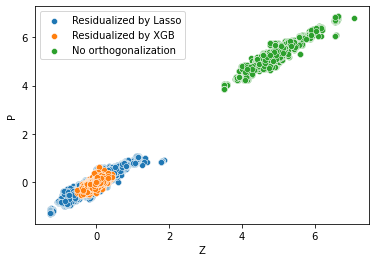

In [29]:
sns.scatterplot(y=p_res_lasso,x=z_res_lasso)
sns.scatterplot(y=p_res,x=z_res)
sns.scatterplot(y=p_test,x=z_test)
plt.xlabel('Z')
plt.ylabel('P')
plt.legend(labels=['Residualized by Lasso', 'Residualized by XGB', 'No orthogonalization'])